## Objective

#### NLP sentiment classification on news headlines
Using APIs or a little webscraping to harvest some new test data that you will manually label the new headlines as negative/positive and then see how your model does on those headlines.

#### Dataset:
[Sentiment Analysis for Financial News](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#to see the entire column width:
pd.set_option('display.max_colwidth', -1)

In [2]:
import tensorflow as tf
tf.__version__

'2.3.1'

### Imoport Data

In [4]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  neutral    
1  neutral    
2  neutral    
3  neutral    
4  positive   

                                                                                                                                                                                       Headline  
0  As an overall effect of the above-mentioned measures Glaston will recognize non-recurring expenses of EUR 12 million in the fourth quarter of 2008 .                                          
1  A total of 131000 Talvivaara Mining Company Plc 's new shares were subscribed for during the period between May 1 , 2010 and June 30 , 2010 under the company 's stock option rights 2007A .  
2  EXEL COMPOSITES IN BRIEF Exel Composites is a technology company which designs , manufactures and markets composite profiles and tubes for industrial applications .                          
3  A total of $ 78 million will be invested in the project .                                                                                                                                     
4  `` I 'm happy with the outcome , '' Sneed said after the hearing .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [5]:
# Look at the instances of each sentiment
df.Sentiment.value_counts()

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

#### Visualize the data

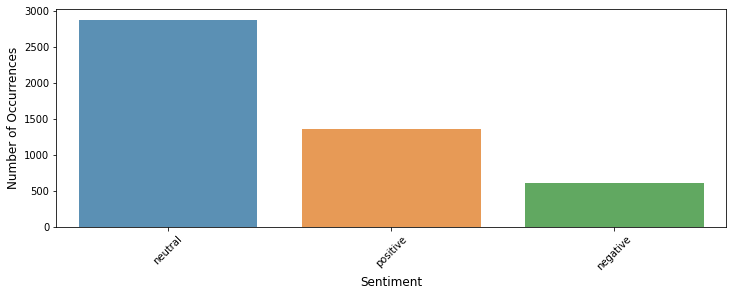

In [6]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

### Clean the Data

In [7]:
# Convert the string in the 'Sentiment' column to numeric form
Sentiment = {'positive': 0, 'neutral': 1, 'negative': 2} 

#df[Sentiment]=df[Sentiment].map(Sentiment)

In [8]:
# traversing through Sentiment column and writing values where key matches
df.Sentiment = [Sentiment[item] for item in df.Sentiment] 
df.head(10)

Sentiment  \
0  1           
1  1           
2  1           
3  1           
4  0           
5  0           
6  1           
7  1           
8  1           
9  0           

                                                                                                                                                                                             Headline  
0  As an overall effect of the above-mentioned measures Glaston will recognize non-recurring expenses of EUR 12 million in the fourth quarter of 2008 .                                                
1  A total of 131000 Talvivaara Mining Company Plc 's new shares were subscribed for during the period between May 1 , 2010 and June 30 , 2010 under the company 's stock option rights 2007A .        
2  EXEL COMPOSITES IN BRIEF Exel Composites is a technology company which designs , manufactures and markets composite profiles and tubes for industrial applications .                                
3  A total of $ 78 million will be invested in the project .                                                                                                                                           
4  `` I 'm happy with the outcome , '' Sneed said after the hearing .                                                                                                                                  
5  - Operating profit rose by 26.9 % to EUR 105.8 ( 83.4 ) million .                                                                                                                                   
6  The report also said Nokia 's operations comprising the sites at Bochum , Ulm , Dusseldorf , Munich and Frankfurt posted operating profit after interest of 246 mln eur .                           
7  `` These developments partly reflect the government 's higher activity in the field of dividend policy . ''                                                                                         
8  LONDON ICIS -- Tikkurila has completed the sale of its powder coatings business to Finnish industrial coatings firm Teknos Group , the Finland-based decorative paints company said on Wednesday .  
9  The brokerage said 2006 has seen a ` true turning point ' in European steel base prices , with better pricing seen carrying through the second quarter of 2006 .

#### Stopwords:
Remove words from strings that have no unique information ('is','an','the).

In [9]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [10]:
#make a new column for clean headlines and then other columns for different version of data

In [11]:
#check
df.head()

Sentiment  \
0  1           
1  1           
2  1           
3  1           
4  0           

                                                                                                                                 Headline  
0  overall effect above-mentioned measures glaston recognize non-recurring expenses eur 12 million fourth quarter 2008                     
1  total 131000 talvivaara mining company plc new shares subscribed period may 1 2010 june 30 2010 company stock option rights 2007a       
2  exel composites brief exel composites technology company designs manufactures markets composite profiles tubes industrial applications  
3  total 78 million invested project                                                                                                       
4  `` 'm happy outcome '' sneed said hearing

#### Lemmatization:
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

In [12]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline_Lemma'] = df['Headline'].map(lemmatize)

In [14]:
#check
df.head()

Sentiment  \
0  1           
1  1           
2  1           
3  1           
4  0           

                                                                                                                                 Headline  \
0  overall effect above-mentioned measures glaston recognize non-recurring expenses eur 12 million fourth quarter 2008                      
1  total 131000 talvivaara mining company plc new shares subscribed period may 1 2010 june 30 2010 company stock option rights 2007a        
2  exel composites brief exel composites technology company designs manufactures markets composite profiles tubes industrial applications   
3  total 78 million invested project                                                                                                        
4  `` 'm happy outcome '' sneed said hearing                                                                                                

                                                                                                                    Headline_Lemma  
0  overall effect above-mentioned measure glaston recognize non-recurring expense eur 12 million fourth quarter 2008                
1  total 131000 talvivaara mining company plc new share subscribed period may 1 2010 june 30 2010 company stock option right 2007a  
2  exel composite brief exel composite technology company design manufacture market composite profile tube industrial application   
3  total 78 million invest project                                                                                                  
4  `` 'm happy outcome '' sneed say hearing

WordCloud to see the commonly used words

In [15]:
#!pip install wordcloud

In [16]:
# Separating out the categories
# pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
# neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [17]:
def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds(column='Headline'):
    # Separating out the categories
    pos = df[column][df.Sentiment[df.Sentiment== 1].index]
    neg = df[column][df.Sentiment[df.Sentiment== 0].index]
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    

Positive Sentiment Wordcloud:


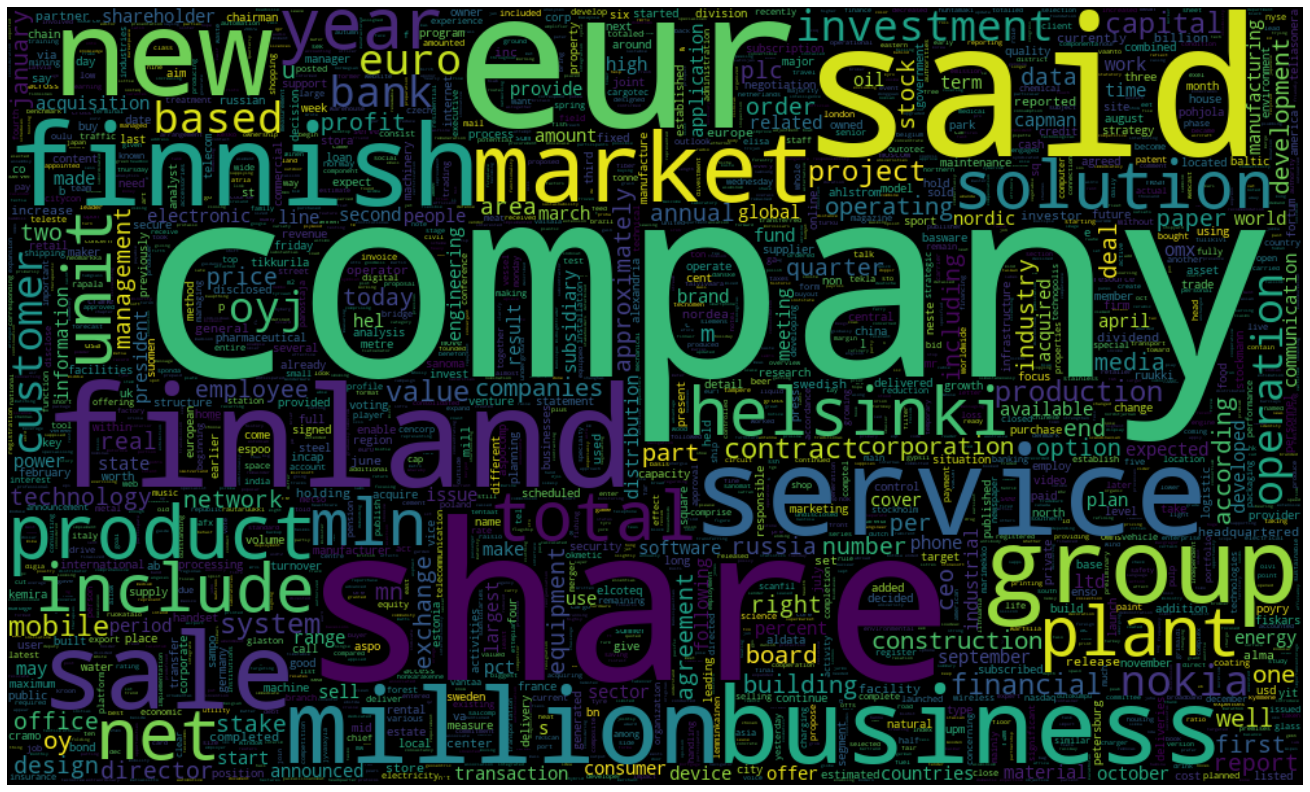

Negative Sentiment Wordcloud:


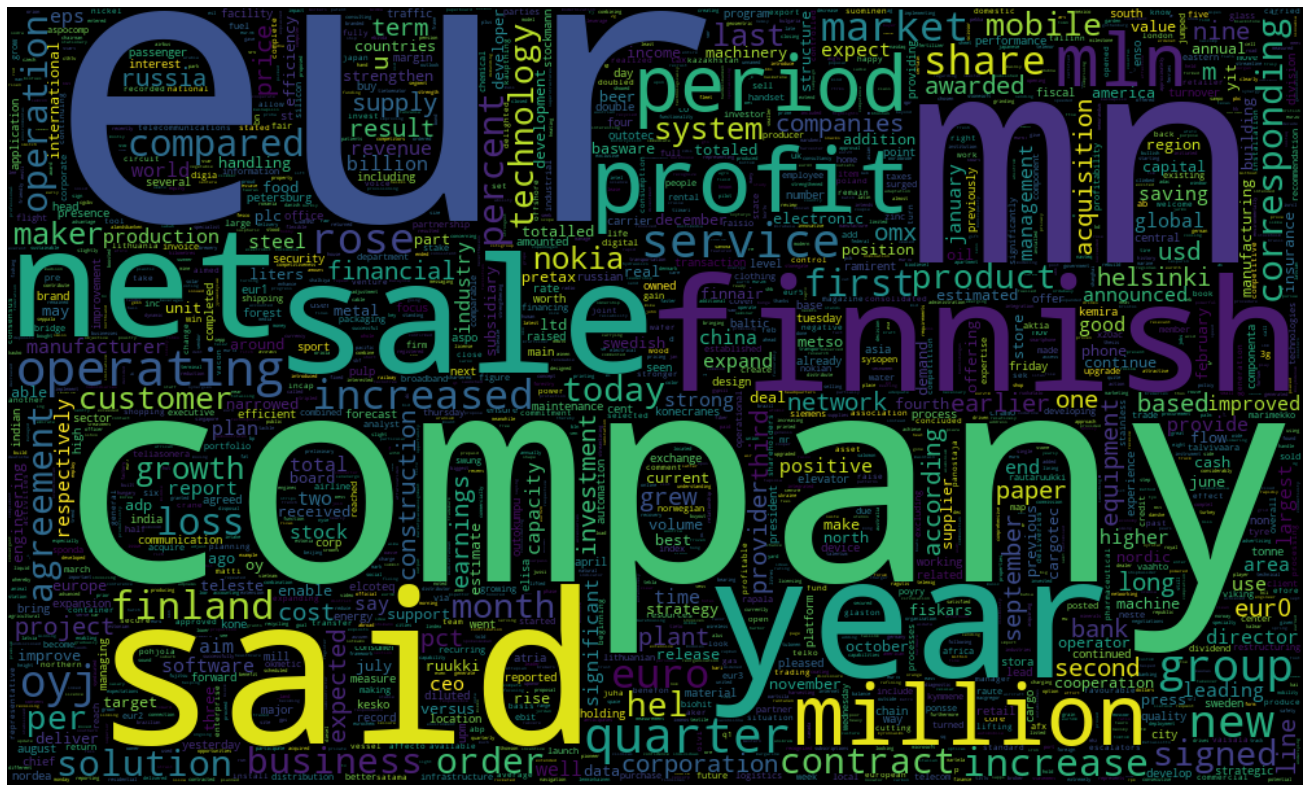

In [18]:
show_wordclouds()

Positive Sentiment Wordcloud:


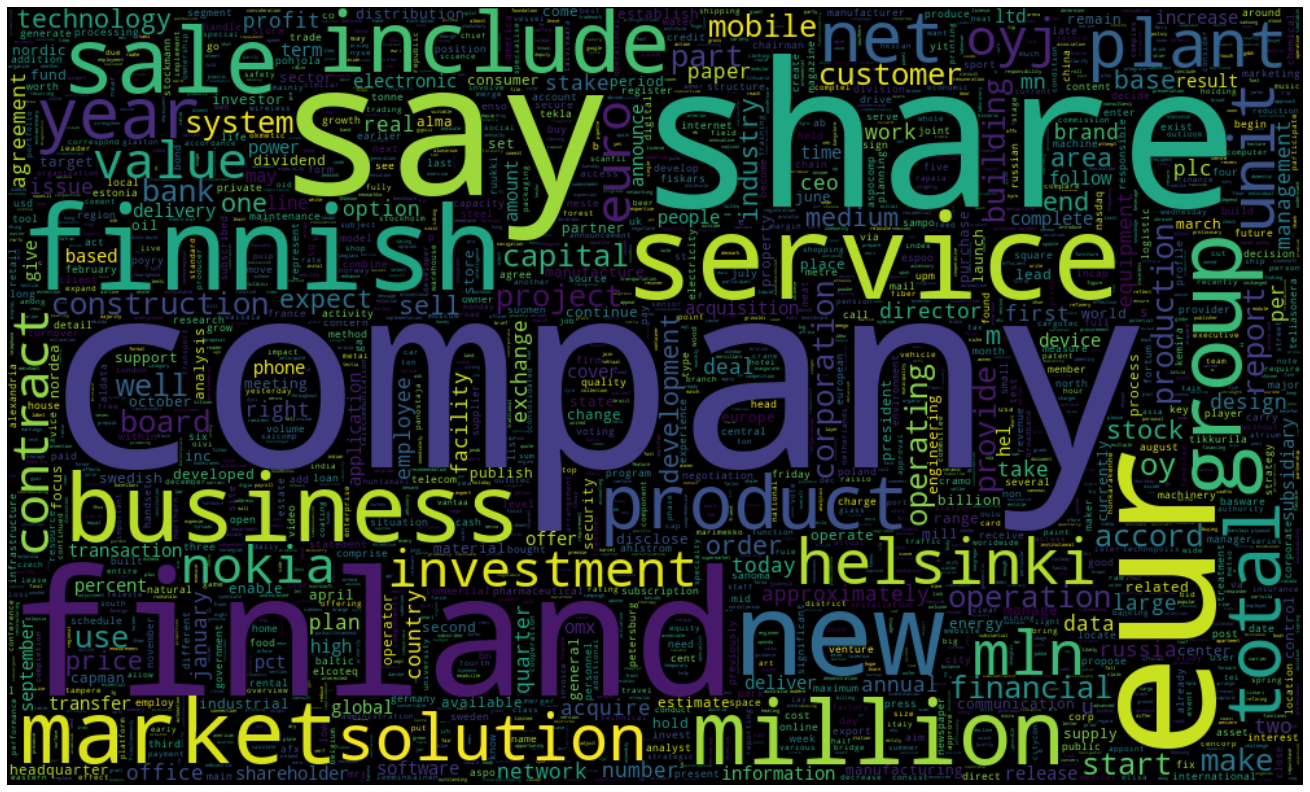

Negative Sentiment Wordcloud:


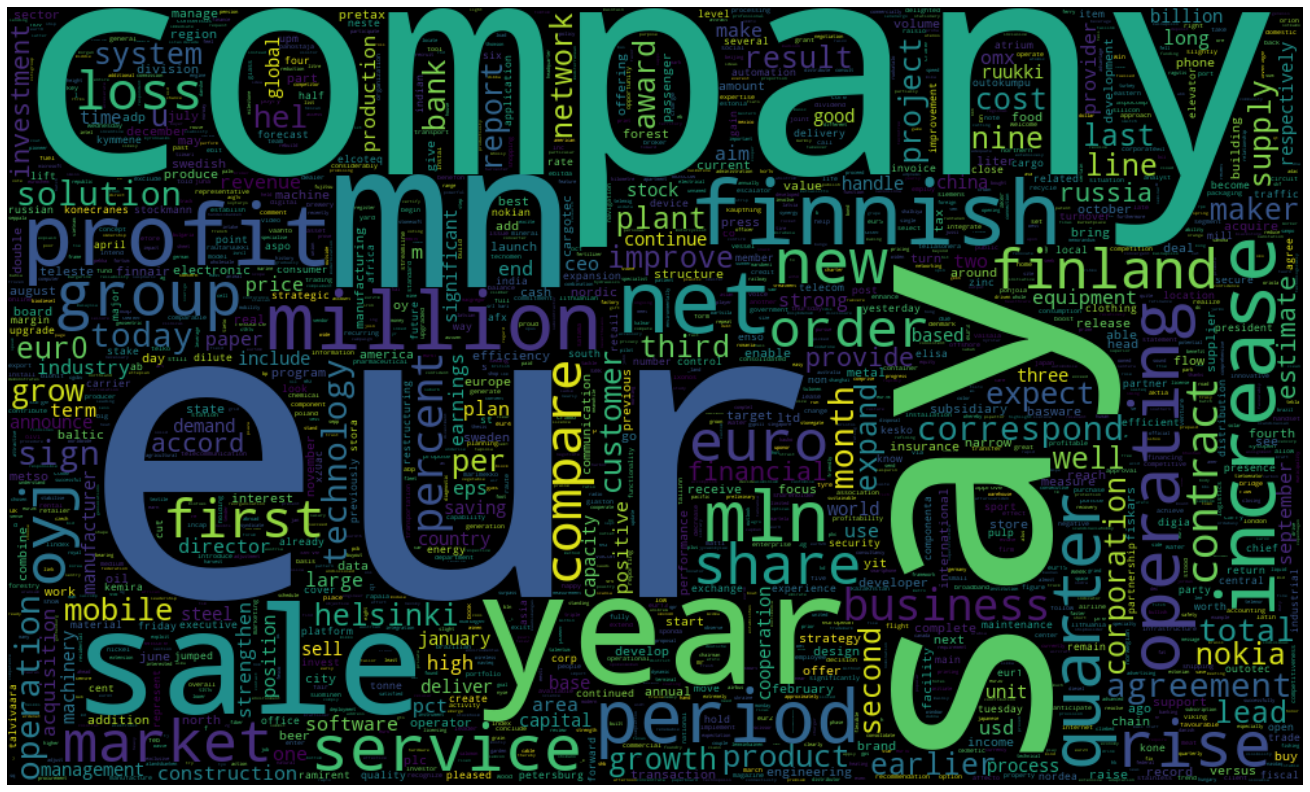

In [19]:
show_wordclouds('Headline_Lemma')

Process the text to convert text to lower-case strip punctuations and symbols etc.

In [20]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


df['Headline_soup'] = df['Headline_Lemma'].apply(cleanText)


In [21]:
df.head()

Sentiment  \
0  1           
1  1           
2  1           
3  1           
4  0           

                                                                                                                                 Headline  \
0  overall effect above-mentioned measures glaston recognize non-recurring expenses eur 12 million fourth quarter 2008                      
1  total 131000 talvivaara mining company plc new shares subscribed period may 1 2010 june 30 2010 company stock option rights 2007a        
2  exel composites brief exel composites technology company designs manufactures markets composite profiles tubes industrial applications   
3  total 78 million invested project                                                                                                        
4  `` 'm happy outcome '' sneed said hearing                                                                                                

                                                                                                                    Headline_Lemma  \
0  overall effect above-mentioned measure glaston recognize non-recurring expense eur 12 million fourth quarter 2008                 
1  total 131000 talvivaara mining company plc new share subscribed period may 1 2010 june 30 2010 company stock option right 2007a   
2  exel composite brief exel composite technology company design manufacture market composite profile tube industrial application    
3  total 78 million invest project                                                                                                   
4  `` 'm happy outcome '' sneed say hearing                                                                                          

                                                                                                                     Headline_soup  
0  overall effect above-mentioned measure glaston recognize non-recurring epense eur 12 million fourth quarter 2008                 
1  total 131000 talvivaara mining company plc new share subscribed period may 1 2010 june 30 2010 company stock option right 2007a  
2  eel composite brief eel composite technology company design manufacture market composite profile tube industrial application     
3  total 78 million invest project                                                                                                  
4  `` 'm happy outcome '' sneed say hearing

#### Counter

In [22]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [23]:
text = df.Headline_Lemma
counter = counter_word(text)

In [24]:
len(counter)

10088

In [25]:
num_words = len(counter)

### Train/Test Split

In [26]:
headlines = []
labels = []

for row in range(len(df)):
    headlines.append(df['Headline_soup'][row])
    labels.append(df['Sentiment'][row])

In [27]:
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(headlines, labels, test_size=0.2 , random_state=42)

In [28]:
# # Setting the training ratio
# training_size = int(df.shape[0] * .8) 

# # Train Test Split:
# # Already shuffled, so we're good to go
# training_headlines = headlines[0:training_size]
# testing_headlines = headlines[training_size:]
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size:]

In [29]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

['food sale total eur 323.5 mn october 2009 represent decrease 5.5 october 2008',
 'new company likely hold ipo nyse another international stock echange accord altimo manages alfa group telecommunication asset teliasonera agreement publish website u.s. security echange commission',
 'ceo company tarmo noop say growth sale premium beer big']

[2, 1, 0]

### Tokenizer 
Tokenizing involoves splitting sentances and words from the body of the text
The use of a tokenizer creates a number coded to each word thereby allowing 
the neural network to build patterns and learn meaning.

In [30]:
# function to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [31]:
# apply the splits to the tokenizer

# Gensim is a Python library for topic modeling, document indexing and Similarity retrieval with large corpora.
#[Gensim](https://pypi.org/project/gensim/)
# train_tagged = train.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)
# test_tagged = test.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)

In [32]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_headlines)
X_train = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(X_train)
print('Found %s unique tokens.' % len(training_padded))


Found 3876 unique tokens.


In [33]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (970, 50)


In [34]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [35]:
# # Initializing the fitting the tokenizer:
# tokenizer = Tokenizer(num_words = num_words, oov_token = oov_tok)
# tokenizer.fit_on_texts(training_headlines)
# # Initializing the Word Index:
# word_index = tokenizer.word_index
# # Padding and Sequencing the Training Set:
# training_sequences = tokenizer.texts_to_sequences(training_headlines)
# training_padded = pad_sequences(training_sequences, maxlen = max_length,
#                                padding = padding_type, 
#                                truncating = trunc_type)
# # Padding and Sequencing the Testing Set:
# testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
# testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
#                                padding = padding_type, 
#                                truncating = trunc_type)


In [36]:
# # Switch to Numpy Array
# # Necessary for the ANN to read the data
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [37]:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', training_headlines[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   56  871    7    7  641   61  311  438
  763   59  438  763  460   65  185  233 3716 3717  438  763   14]

The actual headline:
 nokia message 1.1 enables customer receive e-mail 10 e-mail account mobile phone support pop imap e-mail service

Label:
 1


In [38]:
# train
#train_tagged.values

### Model 1 (Hidden Layer)

In [39]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=64))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

# Slower learning rate worked better as it kept the learning more stable
#opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer='adam', 
              metrics=['accuracy']) # Orig code

In [40]:
# num_epochs = 50
# # After 5 epochs of validation loss not improving, the model will stop.
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# history = model.fit(training_padded, training_labels, 
#                     epochs=num_epochs,
#                     batch_size = 10,
#                     validation_data=(testing_padded, testing_labels), 
#                     verbose= 1, callbacks=[es])

### Functions for Model Evaluation:

In [60]:
results.history.keys()

NameError: name 'results' is not defined

In [41]:



def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
    
#     history = results.history
#     plt.figure()
#     plt.plot(history['val_loss'])
#     plt.plot(history['loss'])
#     plt.legend(['val_loss', 'loss'])
#     plt.title('Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.show()
    
#     plt.figure()
#     plt.plot(history['val_accuracy'])
#     plt.plot(history['accuracy'])
#     plt.legend(['val_acc', 'acc'])
#     plt.title('Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.show()
    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

In [42]:
#model_metrics(model)

In [43]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[[0.49349076]
  [0.50352055]
  [0.5028792 ]
  [0.48999456]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]
  [0.50231993]]

 [[0.49822268]
  [0.49294022]
  [0.49939314]
  [0.5090265 ]
  [0.49850547]
  [0.49477285]
  [0.4975502 ]
  [0.4961560

### Model 2 (LSTM):

In [44]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [45]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Epoch 1/50
162/162 [==============================] - 9s 53ms/step - loss: 0.3901 - accuracy: 0.5962 - val_loss: 0.1556 - val_accuracy: 0.6330
Epoch 2/50
162/162 [==============================] - 8s 52ms/step - loss: -3.9604 - accuracy: 0.6713 - val_loss: -3.3231 - val_accuracy: 0.5536
Epoch 3/50
162/162 [==============================] - 8s 52ms/step - loss: -22.4506 - accuracy: 0.7100 - val_loss: -14.7890 - val_accuracy: 0.5546
Epoch 4/50
162/162 [==============================] - 8s 50ms/step - loss: -49.9565 - accuracy: 0.7162 - val_loss: -16.0309 - val_accuracy: 0.5598
Epoch 5/50
162/162 [==============================] - 8s 49ms/step - loss: -93.8913 - accuracy: 0.7196 - val_loss: -39.0192 - val_accuracy: 0.5268
Epoch 6/50
162/162 [==============================] - 8s 49ms/step - loss: -161.2357 - accuracy: 0.7250 - val_loss: -24.8706 - val_accuracy: 0.5433
Epoch 7/50
162/162 [==============================] - 8s 49ms/step - loss: -231.8347 - accuracy: 0.7407 - val_loss: -56.040

In [46]:
model_metrics(model)

Train Loss: -1243640.332%
Train Accuracy: 81.527%
Test Loss: -411069.727%
Test Accuracy: 60.103%


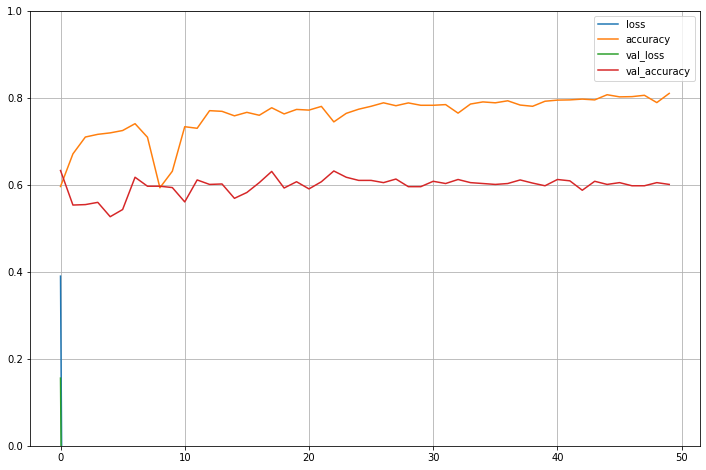

In [47]:
model_eval(history)

In [48]:
from tensorflow.keras.utils import to_categorical
training_labels_ohe = to_categorical(training_labels)
testing_labels_ohe = to_categorical(testing_labels)

testing_labels_ohe[0]

array([1., 0., 0.], dtype=float32)

In [56]:
embedding_dim = 32

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [57]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 32,
                    validation_data=(testing_padded, testing_labels_ohe), 
                    #validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
122/122 [==============================] - 5s 45ms/step - loss: 0.9012 - accuracy: 0.6102 - val_loss: 0.7615 - val_accuracy: 0.6660
Epoch 2/50
122/122 [==============================] - 5s 39ms/step - loss: 0.6763 - accuracy: 0.7051 - val_loss: 0.7362 - val_accuracy: 0.7093
Epoch 3/50
122/122 [==============================] - 5s 39ms/step - loss: 0.4996 - accuracy: 0.7822 - val_loss: 0.7595 - val_accuracy: 0.6856
Epoch 4/50
122/122 [==============================] - 5s 39ms/step - loss: 0.3903 - accuracy: 0.8300 - val_loss: 0.9741 - val_accuracy: 0.6876
Epoch 5/50
122/122 [==============================] - 5s 41ms/step - loss: 0.3160 - accuracy: 0.8460 - val_loss: 1.0681 - val_accuracy: 0.6711
Epoch 6/50
122/122 [==============================] - 5s 39ms/step - loss: 0.2283 - accuracy: 0.8960 - val_loss: 1.0581 - val_accuracy: 0.6979
Epoch 7/50
122/122 [==============================] - 5s 40ms/step - loss: 0.1354 - accuracy: 0.9577 - val_loss: 1.1663 - val_accuracy: 0.6907

In [59]:
model_metrics(model)

ValueError: in user code:

    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [ ]:
model_eval(history) #seperate val and loss